## These are plots formed after saving the data across subjects run in SWRanalysis.ipynb 

In [6]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


## Two regions on same plot

/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_whole.p
CA1: 17567 recalls
Test 1 p-value: 3.132649865405578e-28
Test 2 p-value: 2.0839766282851676e-07
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_dg_6_soz_in_hamming_whole.p
Dentate gyrus: 8755 recalls
Test 1 p-value: 8.325643275244005e-13
Test 2 p-value: 0.01257407607610389


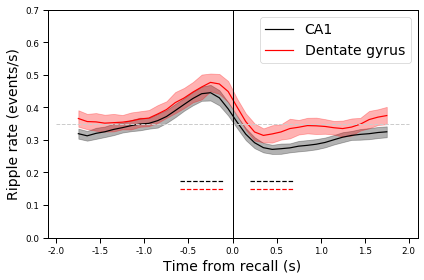

In [8]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 6 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC'
filter_type = 'hamming' # hamming # butter # hamming125200
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
# location_selected = 'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

save_plot = 0

recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

for p,location_selected in enumerate(['ca1','dg']):
    
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,0)
        label = 'CA1'
        line_dist = 0.175
    else:
        color = (1,0,0)
        label = 'Dentate gyrus'
        line_dist = 0.15

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                      '_'+filter_type+'_'+sub_selection+'.p')   
    print(fn)
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']
        binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']

    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data
                    
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')

    # plot bands of significance
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    print(label+': '+str(num_trials)+' recalls')
    print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
    print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
    plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
else: # for Vaz and hamming125200
    ylim = 0.45
    
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'CA1','Dentate gyrus'})
tight_layout()

if save_plot == 1:
    plt.savefig('../figures/PSTHplots/'+exp+'_'+'PSTH_'+region_name+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 
plt.show()
a=1;

## Plot 1st v. ≥2nd on same plot for single region

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_whole.p
1st recalls: 13701 recalls
Test 1 p-value: 0.2400087438058982
Test 2 p-value: 0.0038039511237379134
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_whole.p
≥2nd recalls: 17567 recalls
Test 1 p-value: 3.132649865405578e-28
Test 2 p-value: 2.0839766282851676e-07


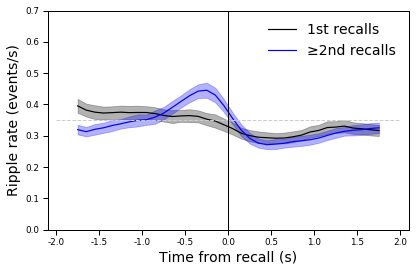

In [34]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
filter_type = 'hamming' # hamming # butter # hamming125200
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'

region_name = 'HPC' # 'ENT' # 'PHC'
location_selected = 'ca1' # 'dg' ''
extra = '' #'-GT_5000' # '-LT_5000' # '' # '-GT_5000' # LT 5000 and GT 5000 are control analyses 
# for first 5000 ms of retrieval period or not

save_plot = 0

recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

set_pubfig()

for p,recall_type_switch in enumerate([4,6]):
    
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
   
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,0)
        label = '1st recalls'
        line_dist = 0.175
    else:
        label = '≥2nd recalls'
        line_dist = 0.15
        if location_selected == 'ca1':
            color = (0,0,1)
        elif location_selected == 'dg':
            color = (1,0,0)
        elif location_selected == 'ca1dg':
            color = (0.5,0,0.5)
        elif region_name == 'PHC':
            color = (0,0.5,0.5)
        elif region_name == 'ENT':
            color = (0.5,0.5,0)

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                      '_'+filter_type+'_'+sub_selection+extra+'.p')   
    print(fn)
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']
        binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']

    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data
                    
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')

#     # plot bands of significance
#     if bin_model1.pvalues[1] < 0.05:
#         plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
#              color=color,label='_nolegend_')
#     if bin_model2.pvalues[1] < 0.05:
#         plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
#              color=color,label='_nolegend_')
    print(label+': '+str(num_trials)+' recalls')
    print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
    print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
    plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
else: # for Vaz and hamming125200
    ylim = 0.45
    
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'1st recalls','≥2nd recalls'},frameon=False)
# if location_selected == '':
#     title(region_name)
# else:
#     title(location_selected)
tight_layout()

if save_plot == 1:
    plt.savefig('../figures/PSTHplots/'+exp+'_'+'PSTH_by_region-'+region_name+'_'+location_selected+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+extra+'.pdf',transparent=True) 
plt.show()
a=1;

## Stats comparing the 1st recalls v. ≥2nd recalls

### single pre-recall bin

In [44]:
# do separate test of 1st v. ≥2nd

import statsmodels.formula.api as smf

region_name = 'HPC' # 'ENT' # 'PHC' #'HPC'
location_selected = 'ca1dg' # 'dg' 'ca1' 'ca1dg'(for LT/GT analyses)
remove_soz_ictal = False

filter_type = 'hamming'
sub_selection = 'whole'
extra = '-GT_5000' #'-LT_5000' # '-LT_5000' # '' # '-GT_5000' # LT 5000 and GT 5000 are control analyses 
# for first 5000 ms of retrieval period or not

for test in [1,2]:

    session_name = []
    subject_name = []
    ripple_rates = []
    indicator = []

    for i_rec,recall_type_switch in enumerate([4,6]):
        
        recall_minimum = 2000
        selected_period = 'surrounding_recall'
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

        path_name = '/home1/john/SWR/figures/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                          '_'+filter_type+'_'+sub_selection+extra+'.p')   
        print(fn)
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']
            subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array']

            indicator.extend(np.tile(str(i_rec),len(session_name_array)))
            session_name.extend(session_name_array)
            subject_name.extend(subject_name_array)
            # remember, the binned_stats_arrays are 500 ms each from -1600:-100 or 200:1700 ms
            if test == 1:
                ripple_rates.extend(binned_first_stats_array[:,2])
            else:
                ripple_rates.extend(binned_second_stats_array[:,0])

    bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,'indicator':indicator,
                                'ripple_rates':ripple_rates})
    vc = {'session':'0+session'}
    sig_bin_model = smf.mixedlm("ripple_rates ~ indicator", bin_df, groups="subject", vc_formula=vc, re_formula="indicator")
    bin_model = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)

    if test == 1:
        print(bin_model.summary())
        print('Test 1 p-value: '+str(bin_model.pvalues[1]))
    else:
        print('Test 2 p-value: '+str(bin_model.pvalues[1]))

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1dg_4_soz_in_hamming_whole-GT_5000.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1dg_6_soz_in_hamming_whole-GT_5000.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     ripple_rates
No. Observations:      27172       Method:                 REML        
No. Groups:            139         Scale:                  0.9883      
Min. group size:       3           Likelihood:             -38539.6392 
Max. group size:       5168        Converged:              Yes         
Mean group size:       195.5                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.404    0.024 16.995 0.000  0.357  0.450
indicator[T.1]                0.013    0.024  0.531 0.595 -0.034  0.059
subject Var                   0.019    0.007                           
subject x indicator[T.1] Cov -0.001    0.005                           
indicator

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### interaction accounting for one second before (after) test 1 (test 2) for 1st v. ≥2nd (Eq. 1)

In [36]:
# do separate test of 1st v. ≥2nd

import statsmodels.formula.api as smf

region_name = 'HPC' # 'ENT' # 'PHC'
location_selected = 'ca1' # 'ca1', 'dg'; '' for 'ENT' or 'PHC'
remove_soz_ictal = False
# extra = ''

filter_type = 'hamming' # butter # hamming # hamming125200
sub_selection = 'second_half' # 'second_half','whole'

for test in [1,2]: # tests 1 and 2 are pre and post recall

    session_name = []
    subject_name = []
    ripple_rates = []
    recall_indicator = []
    bin_indicator = []

    for i_rec,recall_type_switch in enumerate([4,6]):
        
        recall_minimum = 2000
        selected_period = 'surrounding_recall'
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

        path_name = '/home1/john/SWR/figures/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                          '_'+filter_type+'_'+sub_selection+extra+'.p')   
        print(fn)
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']
            subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array']
            
            for i_bin,bn in enumerate([0,2]): # for test 1, 1 second before v. key bin; for test 2, key bin v. 1 second after

                recall_indicator.extend(np.tile(i_rec,len(session_name_array)))
                bin_indicator.extend(np.tile(i_bin,len(session_name_array)))
                session_name.extend(session_name_array)
                subject_name.extend(subject_name_array)
                # remember, the binned_stats_arrays are 500 ms each from -1600:-100 or 200:1700 ms
                if test == 1:
                    ripple_rates.extend(binned_first_stats_array[:,bn])
                else:
                    ripple_rates.extend(binned_second_stats_array[:,2-bn])

    bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,'bin_indicator':bin_indicator,
                                'recall_indicator':recall_indicator,'ripple_rates':ripple_rates})
    vc = {'session':'0+session'}
    model_setup = smf.mixedlm("ripple_rates ~ bin_indicator*recall_indicator",
                                bin_df, groups="subject", vc_formula=vc, re_formula='bin_indicator*recall_indicator')
    
#     bin_model = model_setup.fit(reml=True,method='powell') # shouldn't use this--it doesnt seem to converge for all the coefficients
    bin_model = model_setup.fit(reml=True,method='nm',maxiter=2000) # works for PHC, whole

    if test == 1:
        print(bin_model.summary())
        print('Test 1 interaction p-value: '+str(bin_model.pvalues[3]))
    else:
        print('Test 2 interaction p-value: '+str(bin_model.pvalues[3]))

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_second_half.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_second_half.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             ripple_rates
No. Observations:               38202               Method:                         REML        
No. Groups:                     81                  Scale:                          0.7795      
Min. group size:                14                  Likelihood:                     -49590.6483 
Max. group size:                4398                Converged:                      Yes         
Mean group size:                471.6                                                           
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              0.341

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Test 2 interaction p-value: 0.4279858238760922


### BETWEEN REGION interaction accounting for one second before (after) test 1 (test 2) for 1st v. ≥2nd

In [99]:
# do separate test of 1st v. ≥2nd

import statsmodels.formula.api as smf

region_name1 = 'HPC' # 'ENT' # 'PHC'
location_selected1 = '' # 'ca1', 'dg'; '' for 'ENT' or 'PHC'
region_name2 = 'PHC'
location_selected2 = ''

remove_soz_ictal = False

filter_type = 'hamming'
sub_selection = 'whole' # 'second_half','whole'

session_name = []
subject_name = []
ripple_rates = []
recall_indicator = []
bin_indicator = []
region_indicator = []

for region in [0,1]: # for two regions above
    
    if region == 0:
        region_name = region_name1
        location_selected = location_selected1
    else:
        region_name = region_name2
        location_selected = location_selected2

    for i_rec,recall_type_switch in enumerate([4,6]):
        
        recall_minimum = 2000
        selected_period = 'surrounding_recall'
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

        path_name = '/home1/john/SWR/figures/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                          '_'+filter_type+'_'+sub_selection+'.p')   
        print(fn)
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']
            subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array']
            
            for i_bin,bn in enumerate([0,2]): # for test 1, 1 second before v. key bin; for test 2, key bin v. 1 second after

                recall_indicator.extend(np.tile(i_rec,len(session_name_array)))
                bin_indicator.extend(np.tile(i_bin,len(session_name_array)))
                region_indicator.extend(np.tile(region,len(session_name_array)))
                
                session_name.extend(session_name_array)
                subject_name.extend(subject_name_array)
                # remember, the binned_stats_arrays are 500 ms each from -1600:-100 
                ripple_rates.extend(binned_first_stats_array[:,bn])

bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,'bin_indicator':bin_indicator,
                            'recall_indicator':recall_indicator,'region_indicator':region_indicator,
                            'ripple_rates':ripple_rates})
vc = {'session':'0+session'}
equation = "ripple_rates ~ bin_indicator+recall_indicator+region_indicator+bin_indicator*recall_indicator"+\
            "+bin_indicator*region_indicator+recall_indicator*region_indicator+recall_indicator*region_indicator*bin_indicator"
sig_bin_model = smf.mixedlm(equation, bin_df, groups="subject", vc_formula=vc)
bin_model = sig_bin_model.fit(reml=False, method='nm')

equation2 = "ripple_rates ~ bin_indicator+recall_indicator+region_indicator+bin_indicator:recall_indicator"+\
            "+recall_indicator:region_indicator:bin_indicator"
sig_bin_model2 = smf.mixedlm(equation2, bin_df, groups="subject", vc_formula=vc)
bin_model2 = sig_bin_model2.fit(reml=False, method='nm')

print(bin_model.summary())
print('Test 1 interaction p-value (bin X recall_type): '+str(bin_model.pvalues[4]))
print('Test 1 interaction p-value between regions: '+str(bin_model.pvalues[7]))
print(bin_model2.summary())

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_dg_4_soz_in_hamming_whole.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_dg_6_soz_in_hamming_whole.p
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_PHC__4_soz_in_hamming_whole.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_PHC__6_soz_in_hamming_whole.p
                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           ripple_rates
No. Observations:             47378             Method:                       ML          
No. Groups:                   126               Scale:                        0.7813      
Min. group size:              14                Likelihood:                   -61584.2977 
Max. group size:              6846              Converged:                    Yes         
Mean group size:              376.0                                                       
----------------------------------------------------------------------------------

## Single data plots

Entorhinal cortex: 7401 recalls
Test 1 p-value: 0.30272511334211194
Test 2 p-value: 0.1076246609841942
Entorhinal cortex: 7401 recalls
Test 1 p-value: 0.30272511334211194
Test 2 p-value: 0.1076246609841942


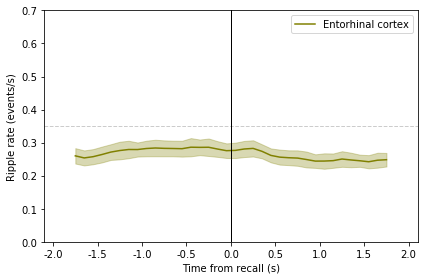

In [40]:
# load data from each

save_plot = 1

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 0 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'ENT' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
location_selected = '' #'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

if region_name == 'PHC':
    legend_name = 'Parahippocampal cortex' #'Parahippocampal cortex' #'Entorhinal'
    color = (0,0.5,0.5)
elif region_name == 'ENT':
    legend_name = 'Entorhinal cortex'
    color = (0.5,0.5,0)
else:
    legend_name = location_selected

line_dist = 0.1

recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

subplots(1,1,figsize=(6,4)); ax2 = plt.gca()

path_name = '/home1/john/SWR/figures/'+subfolder
fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'_'+filter_type+'.p')           
with open(fn,'rb') as f:
    dat = pickle.load(f)
    bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
    bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']; ss = dat['session_name_array']

# make plot
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- CI
if pad > 0:
    SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data
    
    plot(xr[pad:-pad],PSTH[pad:-pad],color=color);
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                 color=color, alpha = 0.3, label='_nolegend_');
else:
    plot(xr,PSTH);
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                 color=color, alpha = 0.3, label='_nolegend_');

# plot bands of significance
if bin_model1.pvalues[1] < 0.05:
    plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
         color=color,label='_nolegend_');
if bin_model2.pvalues[1] < 0.05:
    plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
         color=color,label='_nolegend_');
print(legend_name+': '+str(num_trials)+' recalls')
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax2.set_ylim(0,ylim)
ax2.set_xlim(psth_start-100,psth_end+100)
plot([ax2.get_xlim()[0],ax2.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax2.get_ylim()[0],ax2.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
plt.legend({legend_name})
tight_layout()
print(legend_name+': '+str(num_trials)+' recalls')
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

if save_plot == 1:
    plt.savefig('../figures/PSTHplots/'+exp+'_'+'SINGLE_PSTH_'+region_name+'-'+str(recall_type_switch)+\
                '_'+location_selected+'.pdf',transparent=True) 
plt.show()

a=1;

# Comparison plots for clustering

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


High clustering: 1468 recalls
Low clustering: 1293 recalls
Test 1 comparison p-value: 0.5584774824372933
Test 2 comparison p-value: 0.8923544703781014


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


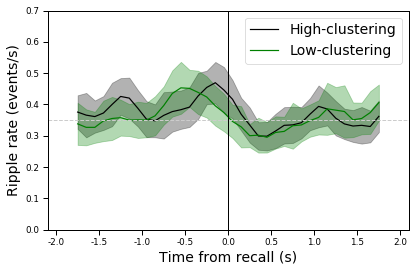

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   ripple_rates
No. Observations:   2761      Method:               REML        
No. Groups:         56        Scale:                0.4598      
Min. group size:    1         Likelihood:           -2873.8193  
Max. group size:    784       Converged:            Yes         
Mean group size:    49.3                                        
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.346    0.032 10.949 0.000  0.284  0.408
category               0.017    0.029  0.585 0.558 -0.040  0.074
subject Var            0.018    0.011                           
subject x category Cov 0.002                                    
category Var           0.000                                    
session Var            0.002    0.006  

In [21]:
# load data from each

save_plot = 0
SE_on = 1

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 6 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
exp = 'catFR1'
region_name = 'HPC'
location_selected = 'dg' #'ca1dg' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)
filter_type = 'hamming'
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'

### settings ###

select_semantic_temporal = 1
# 0 means neither (use for no clustering or subject-level), 
# 1 means semantic 
# 2 means temporal BUT WE DECIDED SHOULD USE 3 FOR LAGS (this uses temporal clustering score which wasnn't as clean)
# 3 temporal by lag. There upper/lower actually means lag=1 and lag≥4

catFR1_all_semantic = 0
# for catFR1:
# if 0 use only remote; 
# if 1 testing *all* semantic trials (or all unclustered...although cleaner to just keep remote unclusetered)
    # since only 4% of trials are adjacent unclustered
    # don't use this one though going to use remote and adjacent separately
# if 2 use adjacent semantic instead of remote semantic (remote is same as with *all* though)
# note that this also matters for subject-level plots and how P(semantically clustered) is calculated
# for FR1 temporal: just set to 0

# select 0.5 or 1.0 seconds before recall
half_second_or_whole = 'whole' # 'whole' 'half'

### end settings ###


recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

session_accum = np.array([])
subject_accum = copy(session_accum)
ripple_accum1 = copy(session_accum)
ripple_accum2 = copy(session_accum)
category = copy(session_accum)

set_pubfig()
for p,upper_label in enumerate(['upper','lower']):
    
#     location_selected = ''
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,0)
        line_dist = 0.175
    else:
        color = (0,0.5,0)
        line_dist = 0.15
        
    path_name = '/home1/john/SWR/figures/'+subfolder
    
    # let's make these filenames easier to understand by giving them names
    if catFR1_all_semantic == 0:
        tt_label = 'remote'
        save_label = 'remoteonly'
    elif catFR1_all_semantic == 1:
        if upper_label == 'upper':
            tt_label = 'all-semantic'
            save_label = 'all-semanticVremote'
        else:
            tt_label = 'remote' # comparison we use for all semantic trials is remote unclustered
    elif catFR1_all_semantic == 2:
        if upper_label == 'upper':
            tt_label = 'adjacent-semantic'
            save_label = 'adjacent-semanticVremote'
        else:
            tt_label = 'remote' # comparison we use for adjacent semantic is still remote unclustered
        
    if select_semantic_temporal == 0:
        st_label = 'neither'
    elif select_semantic_temporal == 1:
        st_label = 'semantic'   
    elif select_semantic_temporal == 2:
        st_label = 'temporalclust'  
    elif select_semantic_temporal == 3:
        st_label = 'lag'  

    fn = os.path.join(path_name,
        'SWRCLUSTER_'+exp+'_'+sub_selection+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+
                      '_'+soz_label+'_'+st_label+'_'+upper_label+'_'+tt_label+'.p')         
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2'];
        binned_first_stats_array = dat['binned_first_stats_array'];binned_second_stats_array = dat['binned_second_stats_array'];
        subject_name_array = dat['subject_name_array'];session_name_array = dat['session_name_array']

    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data
        
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        if SE_on == 1:
            fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                         color=color, alpha = 0.3, label='_nolegend_')
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')

    ## for comparison do ME stats between high and low clustering directly
    session_accum = np.append(session_accum,session_name_array)
    subject_accum = np.append(subject_accum,subject_name_array)
    if half_second_or_whole == 'half':
        ripple_accum1 = np.append(ripple_accum1,binned_first_stats_array[:,2]) # 0:2 are -1600:-100 in 500 ms bins
        ripple_accum2 = np.append(ripple_accum2,binned_second_stats_array[:,0]) # 0:2 are 200:1700 in 500 ms bins
    elif half_second_or_whole == 'whole':
        ripple_accum1 = np.append(ripple_accum1,np.mean(binned_first_stats_array[:,1:],1)) # 0:2 are -1600:-100 in 500 ms bins
        ripple_accum2 = np.append(ripple_accum2,np.mean(binned_second_stats_array[:,0:2],1)) # 0:2 are 200:1700 in 500 ms bins        
    category = np.append(category,np.tile(p,len(session_name_array)))
    
    if p == 1:  # have predictors accumulated for comparison now               
        import statsmodels.formula.api as smf
        
        # pre-recall bump 1st
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum1})
        vc = {'session':'0+session'}
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc,re_formula="category")
        bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
        
        # post_recall valley 2nd
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum2})
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc,re_formula="category")
        bin_model2 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)         
        
#         if bin_model1.pvalues[1] < 0.05:
#             plot([-600,-600+stats_bin],[line_dist,line_dist],'--',
#                  color=(0,0,0),label='_nolegend_')
#         if bin_model2.pvalues[1] < 0.05:
#             plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
#                  color=(0,0,0),label='_nolegend_')
            
        print('High clustering'+': '+str(sum(category==0))+' recalls')
        print('Low clustering'+': '+str(sum(category==1))+' recalls')
        print('Test 1 comparison p-value: '+str(bin_model1.pvalues[1]))
        print('Test 2 comparison p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'Low-clustering','High-clustering'}) # reverse of for loop order since I guess most recent plot gets called first?
tight_layout()

if save_plot == 1:
    plt.savefig('../figures/clusteringPlots/'+exp+'_'+'PSTH_'+region_name+'-'+str(recall_type_switch)+'-'+st_label+'_'+
                location_selected+'_'+save_label+'_'+str(SE_on)+'.pdf',transparent=True) 
plt.show()
print(bin_model1.summary())
a=1;

# Comparison plot for SOZ

Not in SOZ:
Intercept      4.817458e-110
bin[T.1]        1.573010e-16
session Var     2.070292e-10
dtype: float64
In SOZ
Intercept      1.983889e-68
bin[T.1]       1.621130e-13
session Var    1.405880e-04
dtype: float64


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Not in SOZ: 10856 recalls
In SOZ: 6552 recalls
Test 1 *comparison* p-value: 0.39657667437918775
Test 2 *comparison* p-value: 0.6739040465393806


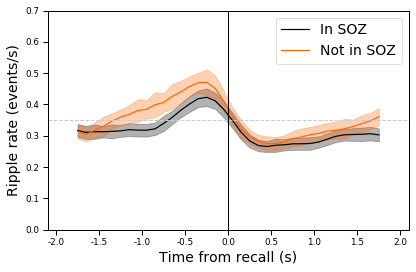

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   ripple_rates
No. Observations:    17408     Method:               REML        
No. Groups:          132       Scale:                0.9554      
Min. group size:     2         Likelihood:           -24395.7722 
Max. group size:     3008      Converged:            Yes         
Mean group size:     131.9                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.422    0.021 20.178 0.000  0.381  0.464
category               -0.030    0.035 -0.848 0.397 -0.098  0.039
subject Var             0.029    0.006                           
subject x category Cov  0.000    0.008                           
category Var            0.011    0.011                           
session Var             

In [5]:
# load data from each

save_plot = 0
SE_on = 1

half_second_or_whole = 'half' # 'whole' 'half'

recall_type_switch = 6 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
exp = 'FR1'
region_name = 'HPC'
location_selected = 'ca1' #'ca1dg' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)
filter_type = 'hamming'
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'

selected_period = 'surrounding_recall' 
recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

session_accum = np.array([])
subject_accum = copy(session_accum)
ripple_accum1 = copy(session_accum)
ripple_accum2 = copy(session_accum)
category = copy(session_accum)

set_pubfig()
for p,remove_soz_ictal in enumerate([1,2]): # this is SOZ removed (1) in SOZ only (2)
    
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

    
#     location_selected = ''
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,0)
        line_dist = 0.175
        print('Not in SOZ:') 
    else:
        color = (1,0.4,0)
        line_dist = 0.15
        print('In SOZ')
    path_name = '/home1/john/SWR/figures/'+subfolder

    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                      '_'+filter_type+'_'+sub_selection+'.p') 
    
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
        orig_test1 = dat['bin_model1']; orig_test2 = dat['bin_model2'];
        binned_first_stats_array = dat['binned_first_stats_array'];binned_second_stats_array = dat['binned_second_stats_array'];
        subject_name_array = dat['subject_name_array'];session_name_array = dat['session_name_array']
       
    print(orig_test1.pvalues)


    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data
        
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        if SE_on == 1:
            fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                         color=color, alpha = 0.3, label='_nolegend_')
#         import ipdb; ipdb.set_trace()
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
        
    ## for comparison do ME stats between first and second directly
    session_accum = np.append(session_accum,session_name_array)
    subject_accum = np.append(subject_accum,subject_name_array)
    
    if half_second_or_whole == 'half':
        ripple_accum1 = np.append(ripple_accum1,binned_first_stats_array[:,2]) # 0:2 are -1600:-100 in 500 ms bins
        ripple_accum2 = np.append(ripple_accum2,binned_second_stats_array[:,0]) # 0:2 are 200:1700 in 500 ms bins
    elif half_second_or_whole == 'whole':
        ripple_accum1 = np.append(ripple_accum1,np.mean(binned_first_stats_array[:,1:],1)) # 0:2 are -1600:-100 in 500 ms bins
        ripple_accum2 = np.append(ripple_accum2,np.mean(binned_second_stats_array[:,0:2],1)) # 0:2 are 200:1700 in 500 ms bins     
    category = np.append(category,np.tile(p,len(session_name_array)))

    if p == 1:  # have predictors accumulated for comparison now               
        import statsmodels.formula.api as smf
        
        # pre-recall bump 1st
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum1})
        vc = {'session':'0+session'}
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc,re_formula="category")
        bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
        
        # post_recall valley 2nd
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum2})
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc,re_formula="category")
        bin_model2 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)        
        
#         if bin_model1.pvalues[1] < 0.05:
#             plot([-600,-600+stats_bin],[line_dist,line_dist],'--',
#                  color=(0,0,0),label='_nolegend_')
#         if bin_model2.pvalues[1] < 0.05:
#             plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
#                  color=(0,0,0),label='_nolegend_')
            
        print('Not in SOZ'+': '+str(sum(category==0))+' recalls')
        print('In SOZ'+': '+str(sum(category==1))+' recalls')
        print('Test 1 *comparison* p-value: '+str(bin_model1.pvalues[1]))
        print('Test 2 *comparison* p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'In SOZ','Not in SOZ'}) # reverse of for loop order since I guess most recent plot gets called first?
tight_layout()

if save_plot == 1:
    plt.savefig('../figures/PSTHplots/'+exp+'_'+'SOZcomparison_PSTH_'+region_name+'-'+str(recall_type_switch)+'_'+
                location_selected+'_'+str(SE_on)+'.pdf',transparent=True) 
plt.show()
print(bin_model1.summary())
a=1;

## Comparison plot for Correct v. Error (intrusions)

Correct:
Intercept      2.344200e-158
bin[T.1]        3.132650e-28
session Var     4.766888e-12
dtype: float64
Error (intrusions)
Intercept      1.550769e-58
bin[T.1]       1.349831e-03
session Var    2.359601e-05
dtype: float64


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Correct: 17567 recalls
Error: 4498 recalls
Test 1 *comparison* p-value: 0.0013508198794251747
Test 2 *comparison* p-value: 0.8360451111150996


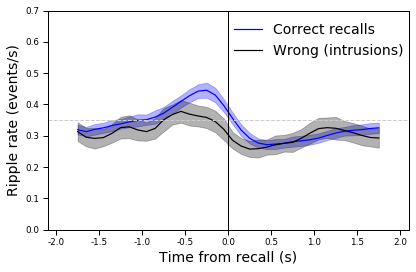

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   ripple_rates
No. Observations:    22065     Method:               REML        
No. Groups:          135       Scale:                0.9453      
Min. group size:     1         Likelihood:           -30795.8471 
Max. group size:     3121      Converged:            Yes         
Mean group size:     163.4                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.415    0.019 22.043 0.000  0.378  0.452
category               -0.067    0.021 -3.205 0.001 -0.108 -0.026
subject Var             0.026    0.005                           
subject x category Cov -0.001    0.004                           
category Var            0.000    0.003                           
session Var             

In [38]:
# load data from each

save_plot = 0
SE_on = 1

half_second_or_whole = 'half' # 'whole' 'half'
recall_type_switch = 6 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
exp = 'FR1'
region_name = 'HPC'
location_selected = 'ca1' #'ca1dg' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)
filter_type = 'hamming'

sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

session_accum = np.array([])
subject_accum = copy(session_accum)
ripple_accum1 = copy(session_accum)
ripple_accum2 = copy(session_accum)
category = copy(session_accum)

set_pubfig()
for p,extra in enumerate(['','-intrusions']): # this is correct v. error
    
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

    
#     location_selected = ''
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        if location_selected == 'ca1':
            color = (0,0,1)
        elif location_selected == 'dg':
            color = (1,0,0)
        line_dist = 0.175
        print('Correct:') 
    else:
        color = (0,0,0)
        line_dist = 0.15
        print('Error (intrusions)')
    path_name = '/home1/john/SWR/figures/'+subfolder

    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                      '_'+filter_type+'_'+sub_selection+extra+'.p') 
    
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
        orig_test1 = dat['bin_model1']; orig_test2 = dat['bin_model2'];
        binned_first_stats_array = dat['binned_first_stats_array'];binned_second_stats_array = dat['binned_second_stats_array'];
        subject_name_array = dat['subject_name_array'];session_name_array = dat['session_name_array']
       
    print(orig_test1.pvalues)


    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data
        
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        if SE_on == 1:
            fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                         color=color, alpha = 0.3, label='_nolegend_')
#         import ipdb; ipdb.set_trace()
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
        
    ## for comparison do ME stats between first and second directly
    session_accum = np.append(session_accum,session_name_array)
    subject_accum = np.append(subject_accum,subject_name_array)
    
    if half_second_or_whole == 'half':
        ripple_accum1 = np.append(ripple_accum1,binned_first_stats_array[:,2]) # 0:2 are -1600:-100 in 500 ms bins
        ripple_accum2 = np.append(ripple_accum2,binned_second_stats_array[:,0]) # 0:2 are 200:1700 in 500 ms bins
    elif half_second_or_whole == 'whole':
        ripple_accum1 = np.append(ripple_accum1,np.mean(binned_first_stats_array[:,1:],1)) # 0:2 are -1600:-100 in 500 ms bins
        ripple_accum2 = np.append(ripple_accum2,np.mean(binned_second_stats_array[:,0:2],1)) # 0:2 are 200:1700 in 500 ms bins     
    category = np.append(category,np.tile(p,len(session_name_array)))
    
    if p == 1:  # have predictors accumulated for comparison now               
        import statsmodels.formula.api as smf
        
        # pre-recall bump 1st
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum1})
        vc = {'session':'0+session'}
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc,re_formula="category")
        bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)
        
        # post_recall valley 2nd
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum2})
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc,re_formula="category")
        bin_model2 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)        
        
#         if bin_model1.pvalues[1] < 0.05:
#             plot([-600,-600+stats_bin],[line_dist,line_dist],'--',
#                  color=(0,0,0),label='_nolegend_')
#         if bin_model2.pvalues[1] < 0.05:
#             plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
#                  color=(0,0,0),label='_nolegend_')
            
        print('Correct'+': '+str(sum(category==0))+' recalls')
        print('Error'+': '+str(sum(category==1))+' recalls')
        print('Test 1 *comparison* p-value: '+str(bin_model1.pvalues[1]))
        print('Test 2 *comparison* p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
leg = ax.legend({'Wrong (intrusions)','Correct recalls'},loc=1,bbox_to_anchor=(1.02,1),frameon=False) # reverse of for loop order since I guess most recent plot gets called first?

tight_layout()

if save_plot == 1:
    plt.savefig('../figures/PSTHplots/'+exp+'_'+'SOZcomparison_PSTH_'+region_name+'-'+str(recall_type_switch)+'_'+
                location_selected+'_'+str(SE_on)+'-intrusions.pdf',transparent=True) 
plt.show()
print(bin_model1.summary())
a=1;

## For each subject with electrodes in both HPC & (ENT or PHC) compare directly

In [11]:
import statsmodels.formula.api as smf

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 6 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
filter_type = 'hamming'
sub_selections = ['first_half','second_half','whole']

min_trials = 20

region_groupings = [
    ['ENT','HPC'],['ENT','HPC'],['PHC','HPC'],['PHC','HPC'],['HPC','HPC'],['PHC','ENT']
]
location_groupings = [
    ['','ca1'],['','dg'],['','ca1'],['','dg'],['dg','ca1'],['','']
]

# regions_to_compare = ['ENT','HPC'] # 'PHC' 'ENT '# put smaller one first so positive values mean a rise
# locations = ['','ca1'] # make sure in brackets #['','ca1'] # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # put '' for no subregions, len=1 (e.g. 'ca1') in for subregion for HPC above, or len=2 (e.g. ['ca1','dg']) to compare regions


pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700
recall_minimum = 2000

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

pairwise_region_values1 = []
pairwise_region_values2 = []

# going to append to a list with 18 lists (3 sub_selections X 6 pairwise region comparisons)
for sub_selection in sub_selections:
    for i_reg,regions_to_compare in enumerate(region_groupings):
        locations = location_groupings[i_reg]

        # get data for each pairwise comparison
        for p,region_name in enumerate(regions_to_compare):

            # select subregion if necessary
            location_selected = locations[p]

            path_name = '/home1/john/SWR/figures/'+subfolder
            fn = os.path.join(path_name,
                'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                              '_'+filter_type+'_'+sub_selection+'.p')          
            with open(fn,'rb') as f:
                dat = pickle.load(f)
                if p == 0:
                    data1_test1 = dat['binned_first_stats_array']; data1_test2 = dat['binned_second_stats_array'];
                    subs1 = dat['subject_name_array']; sessions1 = dat['session_name_array']
                else:
                    data2_test1 = dat['binned_first_stats_array']; data2_test2 = dat['binned_second_stats_array'];
                    subs2 = dat['subject_name_array']; sessions2 = dat['session_name_array']

        # now you have sets of data loaded for two regions along with sub/sess for each-->
        # search across the subjects to find which subjects have electrodes in both regions

        unique_subs1 = np.unique(subs1)    
        unique_subs2 = np.unique(subs2)
        test1_tvalues = []
        test2_tvalues = []
        for possible_sub in unique_subs2: # this one should have fewer since always putting non-temp_loc one 2nd
            if possible_sub in unique_subs1:
                # has electrodes in both! Now do a mixed model just for this subject
                mask1 = subs1==possible_sub
                mask2 = subs2==possible_sub

                if (sum(mask1)>=min_trials) and (sum(mask2)>=min_trials):

                    session_pred = []
                    region_indicator = []
                    test1_outcome = []
                    test2_outcome = []
                    bin_indicator = []
                    for i_bn,bn in enumerate([2]): #([0,2]):
                        session_pred.extend(np.append(sessions1[mask1],sessions2[mask2]))
                        region_indicator.extend(np.hstack((np.tile(0,sum(mask1)),np.tile(1,sum(mask2)))))
                        test1_outcome.extend(np.append(data1_test1[mask1,bn],data2_test1[mask2,bn])) # 2 because 3 bins from -1600:-100 ms were saved          
                        test2_outcome.extend(np.append(data1_test2[mask1,2-bn],data2_test2[mask2,2-bn])) # 0 because 3 bins from 200:1700 ms were saved
                        bin_indicator.extend(np.append( np.tile(i_bn,sum(mask1)),np.tile(i_bn,sum(mask2)) ))

                    # test 1 (-600:-100 ms from recall)
                    test1_df = pd.DataFrame(data={'session_pred':session_pred,'bin_indicator':bin_indicator,
                                'region_indicator':region_indicator,'test1_outcome':test1_outcome})
                    
        #             sig_bin_model = smf.mixedlm("test1_outcome ~ region_indicator*bin_indicator", test1_df, groups="session_pred")
                    # makes sense to just use ripple rates in key bin to compare regions since everything else is controlled
                    sig_bin_model = smf.mixedlm("test1_outcome ~ region_indicator", test1_df, groups="session_pred",re_formula="region_indicator")
                    test1_model = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)

                    # test 2 (200:700 ms from recall)
                    test2_df = pd.DataFrame(data={'session_pred':session_pred,'bin_indicator':bin_indicator,
                                'region_indicator':region_indicator,'test2_outcome':test2_outcome})
                    
        #             sig_bin_model = smf.mixedlm("test2_outcome ~ region_indicator*bin_indicator", test2_df, groups="session_pred")
                    sig_bin_model = smf.mixedlm("test2_outcome ~ region_indicator", test2_df, groups="session_pred",re_formula="region_indicator")
                    test2_model = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)
                
                    test1_tvalues.append(test1_model.tvalues[1]) # 3 for interaction
                    test2_tvalues.append(test2_model.tvalues[1]) # 3 for interaction
        pairwise_region_values1.append(test1_tvalues)
        pairwise_region_values2.append(test2_tvalues)

a=1;

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/

LinAlgError: Singular matrix

whole
['PHC', 'ENT']
['', '']
[ 0.28776572  0.74256037 -0.09651247  1.34094017  0.17405528  1.34138934
 -1.24042754 -0.55982077  2.33273043  0.10944209 -0.19351447 -0.62355758
 -0.29873201  0.28234968 -0.19527422]
[ 0.26223552  0.61857155 -0.16430208  0.270363   -1.1872687  -0.63244748
  1.99410778  0.57782871 -0.01292692  0.15258647  0.79273924 -1.44692788
 -0.00264566  0.22012469  0.18896287]


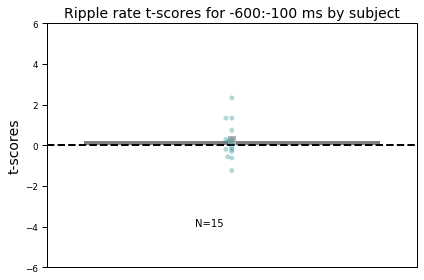

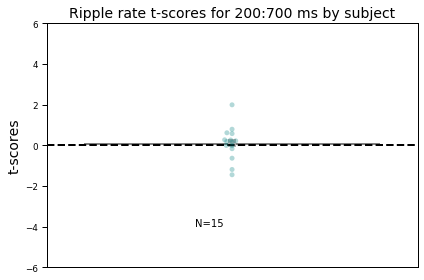

In [22]:
# single comparison plots here and get data to add to dataframe for swarmplot comparisons below

# test 1:
figSub,axSub = plt.subplots(1,1, figsize=(6,4))
test1_tvalues = np.array(test1_tvalues)[~np.isnan(test1_tvalues)]
axSub.bar( 0, np.nanmean(test1_tvalues), yerr = np.nanstd(test1_tvalues)/np.sqrt(len(test1_tvalues)),
          color = (0.5,0.5,0.5), error_kw={'elinewidth':8, 'ecolor':(0.7,0.7,0.7)} )
sb.swarmplot(data=test1_tvalues, ax=axSub, color=(0,0.5,0.5), alpha=0.3)
axSub.plot([axSub.get_xlim()[0],axSub.get_xlim()[1]],[0,0],linewidth=2,linestyle='--',color=(0,0,0),label='_nolegend_')
text(0-0.1,-4,'N='+str(len(test1_tvalues)))
axSub.set(xticks=[])
axSub.set_ylim(-6,6) 
ylabel('t-scores')
title('Ripple rate t-scores for -600:-100 ms by subject')
figSub.tight_layout();

# test 2:
figSub,axSub = plt.subplots(1,1, figsize=(6,4))
test2_tvalues = np.array(test2_tvalues)[~np.isnan(test2_tvalues)]
axSub.bar( 0, np.nanmean(test2_tvalues), yerr = np.nanstd(test2_tvalues)/np.sqrt(len(test2_tvalues)),
          color = (0.5,0.5,0.5), error_kw={'elinewidth':8, 'ecolor':(0.7,0.7,0.7)} )
sb.swarmplot(data=test2_tvalues, ax=axSub, color=(0,0.5,0.5), alpha=0.3)
axSub.plot([axSub.get_xlim()[0],axSub.get_xlim()[1]],[0,0],linewidth=2,linestyle='--',color=(0,0,0),label='_nolegend_')
text(0-0.1,-4,'N='+str(len(test2_tvalues)))
axSub.set(xticks=[])
axSub.set_ylim(-6,6) 
ylabel('t-scores')
title('Ripple rate t-scores for 200:700 ms by subject')
figSub.tight_layout()

print(sub_selection)
print(regions_to_compare)
print(locations)
print(test1_tvalues)
print(test2_tvalues);

In [7]:
len(pairwise_region_values1)
len(pairwise_region_values1[12])
pairwise_region_values1[12]
pairwise_region_values2[12]


18

24

[-0.20704019715442937,
 0.4878369373743559,
 1.7861709743552179,
 -2.058397442550695,
 1.4946235945581285,
 0.8702266196383726,
 2.4390993165894024,
 -3.132510537218447,
 0.20365145161948237,
 1.1965136457410168,
 7.268944439675352e-08,
 -0.3681551221498345,
 nan,
 -6.653692473867664e-08,
 0.9553900330457837,
 2.1370436225376057,
 1.2770523892499193,
 1.8700353210203053,
 2.701246313105332,
 1.339489744934648,
 3.601691014731617,
 3.2743353323171465,
 0.8613787446012907,
 0.417707429433233]

[-0.12144253149871978,
 0.46177634715510163,
 -0.8358622655291419,
 0.014432218609210673,
 0.7019965146976538,
 -3.0643348063857556,
 -0.2819394600358027,
 -2.664125398930644,
 -0.09760940544619166,
 0.5175168521522214,
 nan,
 -0.439998299254371,
 -0.11487405787356539,
 -1.20961778392147e-07,
 0.9934943299518649,
 1.4084486211376939,
 -10.516711561859541,
 1.803566389026815,
 0.15939987204377154,
 1.749169141644526,
 0.4435719671673436,
 0.40173460529741967,
 0.3540176062392561,
 1.194218458324287]

In [ ]:
# ≥2 RECALLS 
%autoreload
# Accumulated data from running above pairwise comparisons with ≥2 recalls only
# and min_trials ≥15 for each region

save_fig = 1
sub_selection = 'whole' # 'whole'
test = 1   # test 1 or test 2? (pre recall bump v. post recall valley)

comp_names = ['CA1 v. ENT','DG v. ENT','CA1 v. PHC','DG v. PHC','CA1 v. DG','ENT v. PHC']
col_names = ['region','t-scores']

# comparisons by subject:
if test == 1:
    pairwise_data = pairwise_region_values1
elif test == 2:
    pairwise_data = pairwise_region_values2
    
# while set of data
if sub_selection == 'first_half':
    comp_data = pairwise_data[0:6]
elif sub_selection == 'second_half':
    comp_data = pairwise_data[6:12]
else:
    comp_data = pairwise_data[12:]

# make plot
fdr_pvalues = makePairwiseComparisonPlot(comp_data,comp_names,col_names)
if test == 1:
    plt.title('Pre-recall ripple t-scores for patients with elec. pairs in both regions')
else:
    plt.title('Post-recall ripple t-scores for patients with elec. pairs in both regions')
xlabel('Regions compared')
tight_layout()
    
if save_fig==1:
    savefig('../figures/t_score_comparisons/Test '+str(test)+' pairwise comparison plot-'+'-'+str(min_trials)+'.pdf',transparent=True)
a=1;

FDR-corrected p-values for each:
[0.0423489  0.01553696 0.01553696 0.12442387 0.14996387 0.72867241]


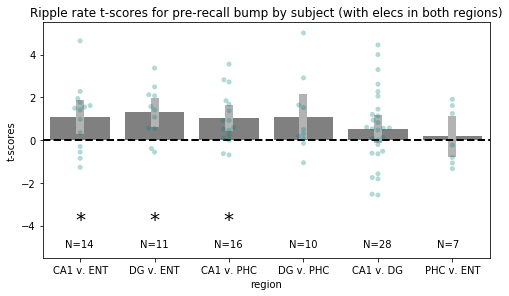

In [217]:
# multiple pairwise comparison plot between each region/subfield:
# (change "test" in last cell to make plots for pre and post-recall bins)
%autoreload

save_fig = 0

# data and labels for plot
comp_data = [ent_ca1,ent_dg,phc_ca1,phc_dg,dg_ca1,ent_phc]
comp_names = ['CA1 v. ENT','DG v. ENT','CA1 v. PHC','DG v. PHC','CA1 v. DG','PHC v. ENT']
col_names = ['region','t-scores']

# make plot
fdr_pvalues = makePairwiseComparisonPlot(comp_data,comp_names,col_names)
if test == 1:
    plt.title('Ripple rate t-scores for pre-recall bump by subject (with elecs in both regions)')
else:
    plt.title('Ripple rate t-scores for post-recall valley by subject (with elecs in both regions)')

if save_fig==1:
    savefig('../figures/t_score_comparisons/Test '+str(test)+' pairwise comparison plot'+'-'+str(min_trials)+'.pdf',transparent=True)
a=1;

In [4]:
from statsmodels.stats.multitest import fdrcorrection

print('%% 1st v. 2nd recalls X 1st v 2nd bin interaction')
print('second half:')
fdrcorrection([6.50E-07,
0.0052,
9.20E-03,
0.13,
6.00E-05,
0.15])
print('whole of same:')
fdrcorrection([7.90E-06,
7.90E-05,
1.90E-03,
1.10E-02,
3.00E-08,
0.15])

print('%% one sample t-tests of subject-level t-scores')
print('second half:')
fdrcorrection([3.30E-05,
0.002,
0.023,
0.49,
8.00E-06,
0.17])
print('whole:')
fdrcorrection([1.80E-08,
5.60E-04,
1.60E-02,
1.70E-01,
6.90E-06,
4.20E-02])

# print('%% contextual reinstatement comparisons (0.5 s bin)')
# print('second half:')
# fdrcorrection([0.042,
# 0.087,
# 0.16,
# 0.79,
# 0.015,
# 0.61])
# print('whole:')
# fdrcorrection([0.0002,
# 0.14,
# 0.0017,
# 0.58,
# 0.0048,
# 0.53])

print('%% contextual reinstatement comparisons (0.5 sec bin)')
print('second half:')
fdrcorrection([0.096,
0.093,
0.31,
0.91,
0.014,
0.64])
print('whole:')
fdrcorrection([0.0062,
0.18,
8.90E-03,
0.51,
3.90E-02,
0.72])

print('%% contextual reinstatement comparisons (1.0 sec bin)')
print('second half:')
fdrcorrection([0.00264,
0.027,
0.00126,
0.95,
0.0592,
0.723])
print('whole:')
fdrcorrection([5.30E-05,
0.011,
8.31E-05,
0.558,
7.92E-02,
0.326])

print('subject-level t-score t-test')
fdrcorrection([0.01818,0.2349])

%% 1st v. 2nd recalls X 1st v 2nd bin interaction
second half:


(array([ True,  True,  True, False,  True, False]),
 array([3.90e-06, 1.04e-02, 1.38e-02, 1.50e-01, 1.80e-04, 1.50e-01]))

whole of same:


(array([ True,  True,  True,  True,  True, False]),
 array([2.37e-05, 1.58e-04, 2.85e-03, 1.32e-02, 1.80e-07, 1.50e-01]))

%% one sample t-tests of subject-level t-scores
second half:


(array([ True,  True,  True, False,  True, False]),
 array([9.90e-05, 4.00e-03, 3.45e-02, 4.90e-01, 4.80e-05, 2.04e-01]))

whole:


(array([ True,  True,  True, False,  True, False]),
 array([1.08e-07, 1.12e-03, 2.40e-02, 1.70e-01, 2.07e-05, 5.04e-02]))

%% contextual reinstatement comparisons (0.5 sec bin)
second half:


(array([False, False, False, False, False, False]),
 array([0.192, 0.192, 0.465, 0.91 , 0.084, 0.768]))

whole:


(array([ True, False,  True, False, False, False]),
 array([0.0267, 0.27  , 0.0267, 0.612 , 0.078 , 0.72  ]))

%% contextual reinstatement comparisons (1.0 sec bin)
second half:


(array([ True, False,  True, False, False, False]),
 array([0.00792, 0.054  , 0.00756, 0.95   , 0.0888 , 0.8676 ]))

whole:


(array([ True,  True,  True, False, False, False]),
 array([2.493e-04, 2.200e-02, 2.493e-04, 5.580e-01, 1.188e-01, 3.912e-01]))

subject-level t-score t-test


(array([ True, False]), array([0.03636, 0.2349 ]))

## compare clustering at subject level: do we see more ripples before recalls for high clustering lists?

In [195]:
import statsmodels.formula.api as smf
from scipy.stats import scoreatpercentile

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 1  # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region = 'HPC' # 'PHC' 'ENT '# put smaller one first so positive values mean a rise
location_selected = '' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# put '' for no subregions, len=1 (e.g. 'ca1') in for subregion for HPC above, or len=2 (e.g. ['ca1','dg']) to compare regions

min_recalls = 4  # keep lists with ≥ this many recalls
upper_label = '' # keeping all trials and splitting within subject

min_trials = 50

use_median = 0 # if 1, split into two halves; if not 1, then use terciles

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

# select subregion if necessary
temp_loc = ''
if region == 'HPC':
    if len(location_selected)>0:
        temp_loc = location_selected
        
path_name = '/home1/john/SWR/figures/'+subfolder
fn = os.path.join(path_name,
    'SWRCLUSTER_'+exp+'_'+region+'_'+temp_loc+'_'+str(recall_type_switch)+
                  '_'+soz_label+'_recalls-'+str(min_recalls)+'_'+upper_label+'.p')           
with open(fn,'rb') as f:
    dat = pickle.load(f)
    data_test1 = dat['binned_first_stats_array']; data_test2 = dat['binned_second_stats_array'];
    subs = dat['subject_name_array']; sessions = dat['session_name_array'];
    clust_scores = dat['temporal_clustering_key'];
    clust_scores_semantic = np.array(dat['semantic_clustering_key']) # semantic wasn't made array in earlier SWRanalysisClustering version
    
# now can split each subject into high and low clustering scores

unique_subs = np.unique(subs)    
test1_tvalues = []
test2_tvalues = []
for ss in unique_subs: # this one should have fewer since always putting non-temp_loc one 2nd
    # Now do a mixed model comparing high v. low clustering just for this subject
    sub_mask = subs==ss
    if sum(sub_mask)>=min_trials:
        if use_median == 1:
            subject_median = np.median(clust_scores[sub_mask])
            if subject_median == 1:
                subject_median = 0.99 # happens on 1 subject with recall_type_switch=2
            low_clust_idxs = clust_scores[sub_mask]<=subject_median
            high_clust_idxs = clust_scores[sub_mask]>subject_median
        else:
            sub_high = scoreatpercentile(clust_scores[sub_mask],200/3)
            sub_low = scoreatpercentile(clust_scores[sub_mask],100/3)
            if sub_high == 1:
                sub_high = 0.99 # just in case
            low_clust_idxs = clust_scores[sub_mask]<=sub_low
            high_clust_idxs = clust_scores[sub_mask]>=sub_high
            if sum(low_clust_idxs) == len(low_clust_idxs) or sum(high_clust_idxs) == len(high_clust_idxs):
                continue # can't use this subject with terciles
            
        category_pred = np.append(np.tile(0,sum(low_clust_idxs)),
                                  np.tile(1,sum(high_clust_idxs)))
        session_pred = np.append(sessions[sub_mask][low_clust_idxs],
                                 sessions[sub_mask][high_clust_idxs])
        test1_outcome = np.append(data_test1[sub_mask,2][low_clust_idxs], # 2 because 3 bins -1600:-100 ms was saved
                                  data_test1[sub_mask,2][high_clust_idxs])
        test2_outcome = np.append(data_test2[sub_mask,0][low_clust_idxs],
                                  data_test2[sub_mask,0][high_clust_idxs])
        # test 1 (-600:-100 ms from recall)
        test1_df = pd.DataFrame(data={'session_pred':session_pred,
                    'category_pred':category_pred,'test1_outcome':test1_outcome})
        sig_bin_model = smf.mixedlm("test1_outcome ~ category_pred", test1_df, groups="session_pred")
        test1_model = sig_bin_model.fit(reml=False, method='nm')

        # test 2 (200:700 ms from recall)
        test2_df = pd.DataFrame(data={'session_pred':session_pred,
                    'category_pred':category_pred,'test2_outcome':test2_outcome})
        sig_bin_model = smf.mixedlm("test2_outcome ~ category_pred", test2_df, groups="session_pred")
        test2_model = sig_bin_model.fit(reml=False, method='nm')
        test1_tvalues.append(test1_model.tvalues[1])
        test2_tvalues.append(test2_model.tvalues[1])

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:209

0.21438668088195398
0.244512354985359


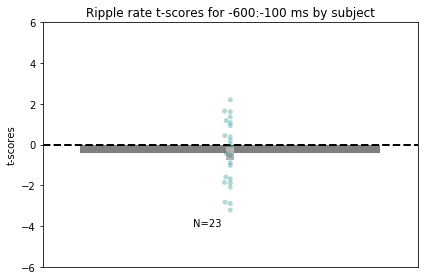

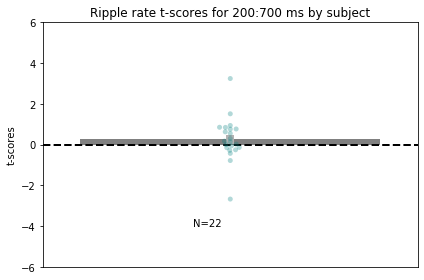

In [196]:
# single comparison plots here and get data to add to dataframe for swarmplot comparisons below

from scipy.stats import ttest_1samp

# test 1:
figSub,axSub = plt.subplots(1,1, figsize=(6,4))
test1_tvalues = np.array(test1_tvalues)[~np.isnan(test1_tvalues)]
axSub.bar( 0, np.nanmean(test1_tvalues), yerr = np.nanstd(test1_tvalues)/np.sqrt(len(test1_tvalues)),
          color = (0.5,0.5,0.5), error_kw={'elinewidth':8, 'ecolor':(0.7,0.7,0.7)} )
sb.swarmplot(data=test1_tvalues, ax=axSub, color=(0,0.5,0.5), alpha=0.3)
axSub.plot([axSub.get_xlim()[0],axSub.get_xlim()[1]],[0,0],linewidth=2,linestyle='--',color=(0,0,0),label='_nolegend_')
text(0-0.1,-4,'N='+str(len(test1_tvalues)))
axSub.set(xticks=[])
axSub.set_ylim(-6,6) 
ylabel('t-scores')
title('Ripple rate t-scores for -600:-100 ms by subject')
figSub.tight_layout()
print(ttest_1samp(test1_tvalues,0)[1])

# test 1:
figSub,axSub = plt.subplots(1,1, figsize=(6,4))
test2_tvalues = np.array(test2_tvalues)[~np.isnan(test2_tvalues)]
axSub.bar( 0, np.nanmean(test2_tvalues), yerr = np.nanstd(test2_tvalues)/np.sqrt(len(test2_tvalues)),
          color = (0.5,0.5,0.5), error_kw={'elinewidth':8, 'ecolor':(0.7,0.7,0.7)} )
sb.swarmplot(data=test2_tvalues, ax=axSub, color=(0,0.5,0.5), alpha=0.3)
axSub.plot([axSub.get_xlim()[0],axSub.get_xlim()[1]],[0,0],linewidth=2,linestyle='--',color=(0,0,0),label='_nolegend_')
text(0-0.1,-4,'N='+str(len(test2_tvalues)))
axSub.set(xticks=[])
axSub.set_ylim(-6,6) 
ylabel('t-scores')
title('Ripple rate t-scores for 200:700 ms by subject')
figSub.tight_layout()
print(ttest_1samp(test2_tvalues,0)[1]);

## For subjects with multiple sessions, can we see consistency of pre-recall bump (or lack of one) for the same electrodes?

In [15]:
import statsmodels.formula.api as smf

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 0 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region = 'HPC' # 'PHC' 'ENT '# put smaller one first so positive values mean a rise
location_selected = ['ca1'] # make sure in brackets #['dg','ca1'] # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# put '' for no subregions, len=1 (e.g. 'ca1') in for subregion for HPC above, or len=2 (e.g. ['ca1','dg']) to compare regions

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700
-
# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
# select subregion if necessary
temp_loc = ''
if region == 'HPC':
    temp_loc = location_selected[0]

path_name = '/home1/john/SWR/figures/'+subfolder
fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region+'_'+temp_loc+'_'+str(recall_type_switch)+'_'+soz_label+'_'+filter_type+'.p')          
with open(fn,'rb') as f:
    dat = pickle.load(f)
    data_test1 = dat['binned_first_stats_array']; data_test2 = dat['binned_second_stats_array'];
    subs = dat['subject_name_array']; sessions = dat['session_name_array'];
    electrode_array = dat['electrode_array']

# now you have sets of data loaded for two regions along with sub/sess for each-->
# search across the subjects to find which subjects have electrodes in both regions

unique_subs = np.unique(subs)    

test1_elec_rates_across_sessions = [] # list of ripples rates by each electrode (list of lists since diff # of sessions for each)
test2_elec_rates_across_sessions = []
key_bin_p_values = []; key_bin_t_values = []
session_p_values = []; session_t_values = []
for ss in unique_subs:
    sub_mask = subs==ss
      
    # for each subject, look for multiple sessions from same subject
    unique_sessions = np.unique(sessions[sub_mask])
    if len(unique_sessions)>1:
        
        # now take first session and get electrode names. Will compare future sessions with 1st only (gets complicated comparing beyond 1st)
        first_session_unique_electrodes = np.unique(electrode_array[sessions==unique_sessions[0]])
        
        for elec in first_session_unique_electrodes:
            electrode_mask = electrode_array==elec
            sessions_with_elec = sessions[sub_mask & electrode_mask] 
            
            if len(np.unique(sessions_with_elec))>1: # if electrode shows up in at least 2 sessions
                temp_list1 = []
                temp_list2 = []
                session_pred = []
                ripple_outcome = []
                category_pred = []
                for sess in np.unique(sessions_with_elec):
                    # now have all sessions with this electrode from given subject
                    test1_vector = data_test1[sub_mask & electrode_mask & (sessions==sess),2]
                    test2_vector = data_test2[sub_mask & electrode_mask & (sessions==sess),2]
                    temp_list1.append(np.mean(test1_vector))
                    temp_list2.append(np.mean(test2_vector))

                    # let's model each electrode and see if electrode ripple rate significantly changes
                    ripple_outcome.extend( np.append(data_test1[sub_mask & electrode_mask & (sessions==sess),0],
                                               data_test1[sub_mask & electrode_mask & (sessions==sess),2]) )
                    session_pred.extend( np.tile(sessions[sub_mask & electrode_mask & (sessions==sess)],2) )
                    category_pred.extend( np.append( np.zeros(len(data_test1[sub_mask & electrode_mask & (sessions==sess),0])),
                                               np.ones(len(data_test1[sub_mask & electrode_mask & (sessions==sess),0])) ) )
                test1_df = pd.DataFrame(data={'session_pred':session_pred,
                        'category_pred':category_pred,'ripple_outcome':ripple_outcome})
                sig_bin_model = smf.ols("ripple_outcome ~ category_pred+session_pred+category_pred*session_pred", test1_df)
                test1_model = sig_bin_model.fit(reml=False)
                key_bin_p_values.append(test1_model.pvalues[2])
                session_p_values.append(test1_model.pvalues[1])
                key_bin_t_values.append(test1_model.tvalues[2])
                session_t_values.append(test1_model.tvalues[1])

                # for raw rate plot by session
                test1_elec_rates_across_sessions.append(temp_list1)
                test2_elec_rates_across_sessions.append(temp_list2)

print('% of electrodes significant for Test 1:')
sum(np.array(key_bin_p_values)<0.05)/len(key_bin_p_values)
print('% of electrodes significantly different across sessions')
sum(np.array(session_p_values)<0.05)/len(key_bin_p_values)

% of electrodes significant for Test 1:


0.04477611940298507

% of electrodes significantly different across sessions


0.014925373134328358

In [278]:
sb.swarmplot(y=key_bin_t_values); show()
sb.swarmplot(y=session_t_values)
ylabel('t-scores for single electrode')
title('t-scores for "session" predictor for same channel in different sessions')

NameError: name 'key_bin_t_values' is not defined

Mean over sessions: 
[0.43550556 0.45828919 0.49305995 0.55831521 0.52378543 0.4853129 ]
StD over sessions:
[0.27876792 0.28643581 0.37641312 0.22049552 0.23167703 0.18190157]


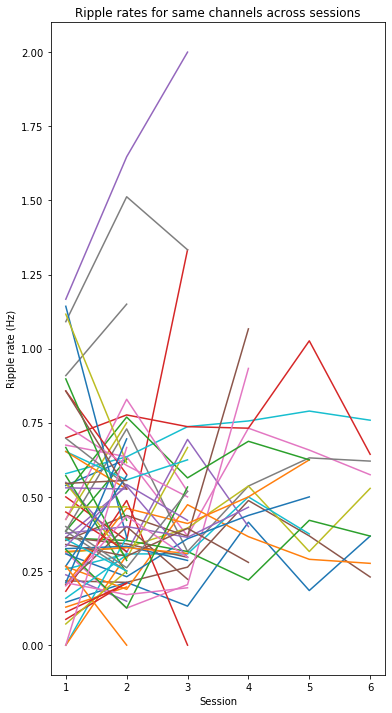

In [17]:
figSub,axSub = plt.subplots(1,1, figsize=(6,12))
for el in test1_elec_rates_across_sessions:
    plot(el)
ylabel('Ripple rate (Hz)')
xlabel('Session')
title('Ripple rates for same channels across sessions')
xticks(range(6),np.arange(6)+1)

from itertools import zip_longest
mean_over_sessions = np.nanmean(np.array(list(zip_longest(*test1_elec_rates_across_sessions)),dtype=float),axis=1)
print('Mean over sessions: ')
print(mean_over_sessions)
print('StD over sessions:')
print(np.nanstd(np.array(list(zip_longest(*test1_elec_rates_across_sessions)),dtype=float),axis=1,ddof=1))
a=1;

## For brainplot I want the t-score for each individual electrode across subjects to plot on the 3D brain

In [30]:
import statsmodels.formula.api as smf

save_coords = 1

exp = 'catFR1'
selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 6  # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls

regions = ['ca1'] #['ENT','PHC'] #['ca1'] #['ca1','dg','ENT','PHC'] # 'PHC' 'ENT '
min_trials = 25

filter_type = 'hamming'
pad = 2
recall_minimum = 2000 # time for recall_type_switch = 3 to determine ISOLATED recalls
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

test1_p_values = []; test1_t_values = []
test2_p_values = []; test2_t_values = []
test1_mean_diff = []; test2_mean_diff = []
final_channel_coords = []; region_array = []

elecs_per_sub = []
channel_save = []

for region in regions:
    
    # did this weird construction in case you want to combine regions. probably just make separate plots though
    location_selected = '' 
    if region == 'ca1':
        region = 'HPC'
        location_selected = 'ca1'
    elif region == 'dg':
        region = 'HPC'
        location_selected = 'dg'

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'_'+filter_type+'.p')          
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        data_test1 = dat['binned_first_stats_array']; data_test2 = dat['binned_second_stats_array'];
        subs = dat['subject_name_array']; sessions = dat['session_name_array'];
        electrode_array = dat['electrode_array']; channel_coords_array = dat['channel_coords_array']

    unique_subs = np.unique(subs)    

    for ss in unique_subs:
        sub_mask = subs==ss

        # for each subject, look for all trials with same electrode
        unique_electrodes = np.unique(electrode_array[sub_mask])
        elecs_per_sub.append(len(unique_electrodes))
        
        # get t-score for each electrode in each region
        
        for elec in unique_electrodes:

            # let's model each electrode and see if electrode ripple rate significantly changes
            elec_mask = electrode_array==elec
            sub_elec_mask = sub_mask & elec_mask
            
            if sum(sub_elec_mask) >= min_trials: # minimum trials
                        
                temp_list1 = []
                temp_list2 = []
                session_pred = []
                ripple_outcome = []
                bin_indicator = []

                ripple_outcome = np.append(data_test1[sub_elec_mask,0],
                                           data_test1[sub_elec_mask,2])
                bin_indicator = np.append( np.zeros(len(data_test1[sub_elec_mask,0])),
                                           np.ones(len(data_test1[sub_elec_mask,2])) )
                session_pred = np.tile(sessions[sub_elec_mask],2)

                test1_df = pd.DataFrame(data={'session_pred':session_pred,
                        'bin_indicator':bin_indicator,'ripple_outcome':ripple_outcome})

# don't remember why I ever set up this OLS model??
#                 if len(np.unique(session_pred))<=0:
#                     sig_bin_model = smf.ols("ripple_outcome ~ bin_indicator+session_pred+bin_indicator*session_pred", test1_df)
#                     test1_model = sig_bin_model.fit()
#                     print('OLS model used for this sub')
#                 else:

                print('ME model used for this sub')
                sig_bin_model = smf.mixedlm("ripple_outcome ~ bin_indicator", test1_df, groups="session_pred")
                test1_model = sig_bin_model.fit(method='nm')
                test1_p_values.append(test1_model.pvalues[1])
                test1_t_values.append(test1_model.tvalues[1])
                test1_mean_diff.append(np.mean(data_test1[sub_elec_mask,2]) - np.mean(data_test1[sub_elec_mask,0]))

                # forget abaout test 2
#                 ripple_outcome = np.append(data_test2[sub_elec_mask,2],
#                                            data_test2[sub_elec_mask,0])
#                 bin_indicator = np.append( np.zeros(len(data_test2[sub_elec_mask,2])),
#                                            np.ones(len(data_test2[sub_elec_mask,0])) )

#                 test2_df = pd.DataFrame(data={'session_pred':session_pred,
#                         'bin_indicator':bin_indicator,'ripple_outcome':ripple_outcome})
#                 if len(np.unique(session_pred))<=1:
#                     sig_bin_model = smf.ols("ripple_outcome ~ bin_indicator+session_pred+bin_indicator*session_pred", test2_df)
#                     test2_model = sig_bin_model.fit()
#                 else:
#                     sig_bin_model = smf.mixedlm("ripple_outcome ~ bin_indicator", test2_df, groups="session_pred")
#                     test2_model = sig_bin_model.fit(method='nm')
#                 test2_p_values.append(test2_model.pvalues[1])
#                 test2_t_values.append(test2_model.tvalues[1])
#                 test2_mean_diff.append(np.mean(data_test2[sub_elec_mask,0]) - np.mean(data_test2[sub_elec_mask,2]))

                # get the coordinates for this channel
                temp_channel_coord = np.unique(channel_coords_array[sub_elec_mask])
                if len(temp_channel_coord)>3: # since xyz for each (ML/AP/DV)
                    print('more than 1 set of coordinates for a channel??')
                    continue
                else:
                    final_channel_coords.append(channel_coords_array[sub_elec_mask][0]) # unique sorts the results so take original order
                    region_array.append(region+location_selected)
                
print('% of electrodes significant for Test 1:')
sum(np.array(test1_p_values)<0.05)/len(test1_p_values)
print('% of electrodes significantly different across sessions')
sum(np.array(test2_p_values)<0.05)/len(test2_p_values)

if (exp == 'catFR1') & ('ca1' in regions):
    orig_coords = copy(final_channel_coords)
    final_channel_coords = [i for i in final_channel_coords if ((i[1]>-50) & (i[1]<0))]
    region_array = [region_array[idx] for idx,i in enumerate(orig_coords) if ((i[1]>-50) & (i[1]<0))]
    test1_t_values = [test1_t_values[idx] for idx,i in enumerate(orig_coords) if ((i[1]>-50) & (i[1]<0))]

if save_coords == 1:
    fn = '../figures/t_score_comparisons/'+exp+'_'+region+'_'+location_selected+'_sub_channel_t-scores-min-'+\
        str(min_trials)+'_trials-'+str(recall_type_switch)+'.npz'
    np.savez(fn, t_values=test1_t_values, coords=final_channel_coords, region_array = region_array)
    print('saved coords')

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home1/john/an

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarni

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
ME model used for this sub
% of electrodes significant for Test 1:


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


0.16911764705882354

% of electrodes significantly different across sessions


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in long_scalars


nan

saved coords


In [42]:
    fn = '../figures/t_score_comparisons/'+exp+'_'+region+'_'+location_selected+'_sub_channel_t-scores-min-'+\
        str(min_trials)+'_trials-'+str(recall_type_switch)+'.npz'
    np.savez(fn, t_values=test1_t_values, coords=final_channel_coords, region_array = region_array)

[1.4135602553846713,
 -0.4237017130659008,
 2.1439579088313745,
 0.44820337228167684,
 0.4546283428155189,
 2.168694480392562e-16,
 -0.5879837642853729,
 1.2937797690150914,
 2.4368307963206863,
 2.1609226225224826e-16,
 0.4896182465934662,
 2.0243287331153508,
 1.3081862034242637,
 -0.1650225002410696,
 2.541536660119082,
 0.9377544715409769,
 2.5069495077438706,
 0.43138365524286754,
 2.452070554273003,
 -0.1756612973281542,
 2.239300777735873,
 0.5615890761720329,
 2.194985943842154,
 0.11177547882372849,
 1.00977328034333,
 0.0,
 2.709207600986443,
 0.138334587954422,
 0.0,
 -0.48036916717429806,
 1.939229205394411,
 1.8918065355138007,
 -2.3151015297177318,
 -2.1259760138109356,
 -1.1617407204174994,
 0.0,
 4.028547299197243,
 -0.9334524930892822,
 0.8667488883209771,
 1.353940341412998,
 0.0,
 -0.8128664117110607,
 -0.8502651466878618,
 1.9489962987235656,
 -0.26946514611012856,
 1.03482662399664,
 0.38899330260774956,
 0.6600641236295944,
 0.8372826512409755,
 -1.460062651305222

In [270]:
sum(elecs_per_sub)
len(region_array)
len(final_channel_coords)
len(unique(subs))
len(np.unique(electrode_array))
np.unique(electrode_array)

76

36

36

42

39

array(['1LD2-1LD3', '3Ld2-3Ld3', '5Ld1-5Ld2', '6Rd2-6Rd3', 'HB2-HB3',
       'LAHD1-LAHD2', 'LAHD2-LAHD3', 'LAS1-LAS2', 'LB1-LB2', 'LB2-LB3',
       'LB3-LB4', 'LC1-LC2', 'LC2-LC3', 'LC3-LC4', 'LD2-LD3', 'LDH3-LDH4',
       'LMHD2-LMHD3', 'LOTD3-LOTD4', 'LOTD4-LOTD5', 'LPHCD1-LPHCD2',
       'LPHCD2-LPHCD3', 'LPHCD3-LPHCD4', 'LPHCD4-LPHCD5', 'LPHD1-LPHD2',
       'RAHCD2-RAHCD3', 'RB1-RB2', 'RB2-RB3', 'RB3-RB4', 'RB4-RB5',
       'RB5-RB6', 'RC1-RC2', 'RC2-RC3', 'RC3-RC4', 'RDH1-RDH2',
       'RDH2-RDH3', 'RDH3-RDH4', 'RMD1-RMD2', 'RMD2-RMD3',
       'RPHCD1-RPHCD2'], dtype='<U13')

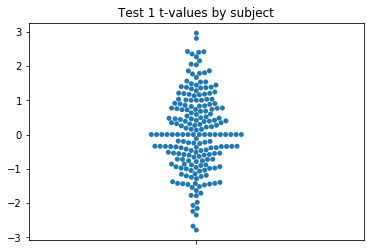

P(greater than 0): 0.49246231155778897


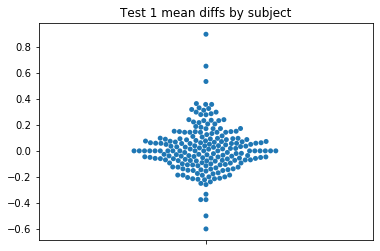

P(greater than 0): 0.46733668341708545


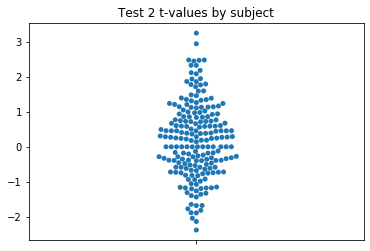

P(greater than 0): 0.5276381909547738


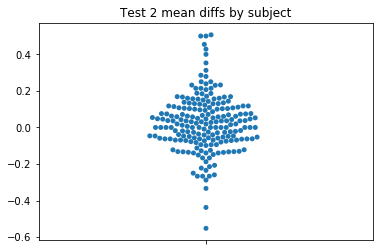

P(greater than 0): 0.5276381909547738


In [277]:
# plot the distribution of t-values:
sb.swarmplot(y=test1_t_values); title('Test 1 t-values by subject'); show()
print('P(greater than 0): '+str(sum(np.array(test1_t_values)>0)/len(test1_t_values)))
sb.swarmplot(y=test1_mean_diff); title('Test 1 mean diffs by subject'); show()
print('P(greater than 0): '+str(sum(np.array(test1_mean_diff)>0)/len(test1_mean_diff)))
sb.swarmplot(y=test2_t_values); title('Test 2 t-values by subject'); show()
print('P(greater than 0): '+str(sum(np.array(test2_t_values)>0)/len(test2_t_values)))
sb.swarmplot(y=test2_mean_diff); title('Test 2 mean diffs by subject'); show()
print('P(greater than 0): '+str(sum(np.array(test2_mean_diff)>0)/len(test2_mean_diff)));

In [ ]:
# original region pairwise comparison first_half data:

#test 1
        ent_ca1 = [-0.85098251,  1.54166296,  4.63857452, -0.3015888 , -1.26860286,
                0.96750138,  1.94227705,  1.40829184,  1.49079247, -0.55716642,
                1.76256298,  0.34580046,  1.61287741,  2.27550001] 
        ent_dg = [ 0.5513075 ,  1.41499855,  1.56763262,  3.36310246, -0.39345704,
                2.12069449, -0.55947386,  2.07469222,  0.53792351,  1.07474658,
                2.48864782]
        phc_ca1 = [ 0.9227761 ,  0.45469161,  3.55058019,  0.92323064,  2.81916607,
                1.67553711, -0.63377728,  1.3715776 ,  2.71672923, -0.69216144,
                0.22196863,  0.        ,  0.51767695,  0.08305765,  1.84423832,
                0.57804047]
        phc_dg = [ 1.63678641, -0.15270266,  2.90780426, -1.05654109,  1.51766529,
                5.00670316,  0.18577161,  0.2937039 ,  0.49145871,  0.07123431]
        dg_ca1 = [-1.57229228,  0.        ,  0.5662012 ,  0.93370889,  3.996451  ,
                2.05480467,  0.55332263,  0.53129917, -2.56658197,  2.26742746,
                1.12976265,  0.5985056 , -0.61333888,  3.29413508, -2.52580118,
                2.61367083, -1.81275028, -0.63883855,  0.08191849,  4.44774799,
               -0.20899041,  1.44756621,  1.20283353,  0.46837062, -0.51786659,
                0.11687449, -1.74865804,  0.81911242]
        ent_phc = [-1.06789294,  1.90488159, -1.33252431, -0.8112575 , -0.23843643,
                1.61614984,  1.24118203]
# test 2
        ent_ca1 = [-1.47821818,  1.21383203,  4.96331649,  7.14628453, -2.82560444,
               -0.76256003,  0.28365431, -1.61677004,  1.42472831,  1.16554303,
               -1.37117396]
        ent_dg = [-5.39687072e-01,  5.66957601e-01,  2.17509216e+00, -8.03405889e-01,
               -2.82348410e+00,  2.46717582e-01,  3.71880921e-01,  8.95995922e-17,
                6.18079665e-01,  1.05654109e+00, -1.16085890e-01]
        phc_ca1 = [ 0.45747373,  1.19145221,  3.98369836,  1.77863836,  0.45174019,
                0.68265615, -2.12462429,  1.31448103,  1.19432621,  1.21762668,
                0.95684317,  0.58172053]
        phc_dg = [ 2.28085776,  0.49332851,  1.32418567, -0.47360222, -0.17065162,
                3.1991913 ,  1.04071829, -0.90453403, -0.65436873,  0.43019267]
        dg_ca1 = [-1.03386828e+00,  1.01904933e+00, -9.87420883e-01,  1.02318563e+00,
                2.28089958e+00,  1.42837966e+00, -1.33598613e+00,  9.17718823e-01,
               -1.25634334e+00,  3.43562832e-01,  1.77975074e+00,  1.07474658e+00,
               -5.51998257e-01,  2.22206728e+00, -1.47797062e+00,  2.22443486e+00,
                0.00000000e+00, -1.96708071e+00,  1.59499294e+00,  1.31003381e+00,
                2.44528099e+00, -1.85077636e+00,  2.31183881e+00,  6.45893114e-01,
                1.60570673e-16, -1.59547039e+00,  7.16705720e-01]
        ent_phc = [-2.59366765,  2.13489435, -0.5744792 ,  0.44973256, -2.2198577 ,
               -0.73379939,  0.67127475]